In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # TrueType fonts to be ICPR compatible
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from tqdm.notebook import tqdm

In [4]:
PATH="../results/"
PATTERN="hourly-{method}-{features}-{dates}-seed{seed}-bias.res"
PATTERN_ENSEMBLE="hourly-{method}-{features}-{dates}-ensemble{nmodels}-seed{seed}-bias.res"
def load_data(method='LIMES', features='tweet', dates='0_5', seeds=range(10)):
    DATA=[]
    for seed in seeds:
        filename = PATH+PATTERN.format(method=method, features=features, dates=dates, seed=seed)
        data = np.loadtxt(filename, usecols=[1])
        data = np.insert(data, 0, 1/250)[:-1] # add first value, remove last
        DATA.append(data)
    return np.vstack(DATA)

In [5]:
RES,AVG_ACC,MIN_ACC = {},{},{}
for feats in ['tweet','location','tweet_location']:
    for dates in ['0_5' ,'10_15']:
        for method in ['LIMES','incremental','restart','ensemble', 'random']:
            res = load_data(method=method,features=feats,dates=dates)
            RES[(feats,dates,method)] = res
            avg_res = res.mean(axis=1)
            min_res = res.reshape(10,-1,24).min(axis=-1).mean(axis=1)
            AVG_ACC[(feats,dates,method)] = avg_res.mean(),avg_res.std()
            MIN_ACC[(feats,dates,method)] = min_res.mean(),min_res.std()

DATASOURCE = {'avg':AVG_ACC, 'min':MIN_ACC}

In [8]:
def print_table_all(data):
    print("%", data)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|cccccc}")
    for method in ['header','LIMES','incremental']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for dates in ['0_5','10_15']:
            for feats in ['tweet','location','tweet_location']:
                if method == 'header':
                    print_dates = dates.replace('_','-')
                    print_feats = feats.replace('_','-')
                    print("& \\textbf{{{} {}}}".format(print_feats,print_dates), end="")
                else:
                    m,s = datasource[(feats,dates,method)]
                    print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
def print_table_feats(data, dates):
    print("%", data, dates)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|ccc}")
    for method in ['header','LIMES','incremental']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for feats in ['tweet','location','tweet_location']:
            if method == 'header':
                print_feats = feats.replace('_','-')
                print("& \\textbf{{{}}}".format(print_feats), end="")
            else:
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
def print_table_dates(data, feats):
    print("%", data, feats)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|cc}")
    for method in ['header','LIMES','incremental', 'random']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for dates in ['0_5','10_15']:
            if method == 'header':
                print_dates = dates.replace('_','-')
                print("& \\textbf{{{}}}".format(print_dates), end="")
            else:
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
dates_name = {'0_5':'early', '10_15':'late'}

def print_table_data(feats, dates):
    print("\\begin{subfigure}{.3\\textwidth}\\centering")
    print("\caption{features: \\emph{"+feats.replace('_','--')+"}, subset: \emph{"+dates_name[dates]+"} }")
    print("\\begin{tabular}{c|cc}")
    for method in ['header','LIMES','incremental','ensemble','restart', 'random']:
        if method=='header':
            print("\\textbf{method}", end="")
        else:
            print(method, end="")
        for data in ['avg','min']:
            if method == 'header':
                print("& \\textbf{{avg of {}}}".format(data), end="")
            else:
                datasource = DATASOURCE[data]
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    print("\\end{subfigure}")

In [9]:
for dates in ['0_5','10_15']:
    for feats in ['tweet','location','tweet_location']:
        print_table_data(feats,dates)

\begin{subfigure}{.3\textwidth}\centering
\caption{features: \emph{tweet}, subset: \emph{early} }
\begin{tabular}{c|cc}
\textbf{method}& \textbf{avg of avg}& \textbf{avg of min}\\\hline
LIMES& $52.35_{\pm 0.04}$ & $43.15_{\pm 0.21}$ \\
incremental& $51.81_{\pm 0.05}$ & $40.51_{\pm 0.25}$ \\
ensemble& $38.94_{\pm 0.03}$ & $29.48_{\pm 0.18}$ \\
restart& $34.28_{\pm 0.05}$ & $24.62_{\pm 0.27}$ \\
random& $48.85_{\pm 0.13}$ & $35.13_{\pm 0.71}$ \\
\end{tabular}
\end{subfigure}
\begin{subfigure}{.3\textwidth}\centering
\caption{features: \emph{location}, subset: \emph{early} }
\begin{tabular}{c|cc}
\textbf{method}& \textbf{avg of avg}& \textbf{avg of min}\\\hline
LIMES& $81.23_{\pm 0.03}$ & $75.20_{\pm 0.07}$ \\
incremental& $81.09_{\pm 0.03}$ & $74.49_{\pm 0.14}$ \\
ensemble& $68.48_{\pm 0.05}$ & $62.09_{\pm 0.13}$ \\
restart& $54.33_{\pm 0.05}$ & $44.28_{\pm 0.17}$ \\
random& $79.72_{\pm 0.06}$ & $71.84_{\pm 0.50}$ \\
\end{tabular}
\end{subfigure}
\begin{subfigure}{.3\textwidth}\centering

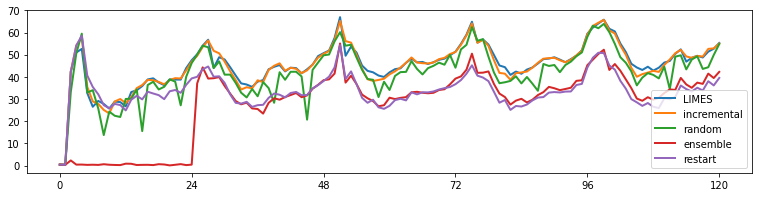

In [11]:
def plot_curve(method, features='tweet', subset='0_5'):
    res = 100*RES[features,subset,method][0]
    plt.plot(range(start,end),res[start:end],label=method, linewidth=2)

start,end = 0,121
fig=plt.figure(figsize=(13,3))
plot_curve(method="LIMES")
plot_curve(method="incremental")
plot_curve(method="random")
plot_curve(method="ensemble")
plot_curve(method="restart")
plt.xticks(range(start,end,24))
plt.legend()
plt.savefig("accuracy-plot-tweet-0_5.svg", bbox_inches='tight', pad_inches=0)
plt.savefig("accuracy-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0)

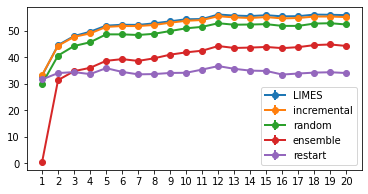

In [12]:
def plot_aggregate_curve(methods, features='tweet', subset='0_5', op='avg'):
    DATASOURCE = {'avg':AVG_ACC, 'min':MIN_ACC}
    
    for method in methods:
        res = 100*RES[(features,subset,method)].reshape(10,-1,24)
        if op == 'avg':
            res = res.mean(axis=-1)
        elif op == 'min':
            res = res.min(axis=-1)
        else:
            print("Unknown operation")
            return
        m,s = res.mean(axis=0),res.std(axis=0)
        plt.errorbar(x=range(1,len(m)+1),y=m,yerr=s,label=method, marker='o', linewidth=2)
        plt.xticks(range(1,len(m)+1))

fig=plt.figure(figsize=(6,3))
plot_aggregate_curve(methods=["LIMES", "incremental", "random", "ensemble", "restart"])
plt.legend()
plt.savefig("accuracy_avg-plot-tweet-0_5.svg", bbox_inches='tight', pad_inches=0)
plt.savefig("accuracy_avg-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0)

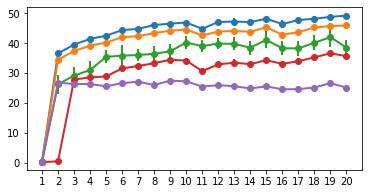

In [13]:
fig=plt.figure(figsize=(6,3))
plot_aggregate_curve(methods=["LIMES", "incremental", "random", "ensemble", "restart"], op='min')
plt.savefig("accuracy_min-plot-tweet-0_5.svg", bbox_inches='tight', pad_inches=0)
plt.savefig("accuracy_min-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0)